In [ ]:
# !pip install pandas
# !pip install numpy
!pip install prophet
!pip install plotnine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.9 MB 4.4 MB/s 
     |████████████████████████████████| 179 kB 39.9 MB/s 
     |████████████████████████████████| 73 kB 2.5 MB/s 
     |████████████████████████████████| 45 kB 2.7 MB/s 
  Attempting uninstall: holidays
    Found existing installation: holidays 0.10.5.2
    Uninstalling holidays-0.10.5.2:
      Successfully uninstalled holidays-0.10.5.2
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the 

In [ ]:
# import more necessary libraries
import numpy as np # linear algebra
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')  # Hide warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
#import pandas_datareader.data as web
import matplotlib.pyplot as plt
#import seaborn as sns
#import matplotlib.dates as mdates
import pandas as pd
#from plotnine import *
import io
# we'll use the statistics package to conduct some predictive analytics
import statistics as st
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from  sklearn.metrics import mean_absolute_error
import holidays

### Stock price prediction

In [62]:
# Let's convert the datafile into a dataframe
df = pd.read_csv('/content/drive/MyDrive/prophet_data/Used_Data/TTT.csv')
df = df[['Date','Adj Close']]
df.columns = ['ds', 'y']
df

,ds,y
0,2017-04-19,47.106853
1,2017-04-20,47.762440
2,2017-04-21,47.884815
3,2017-04-24,47.919788
4,2017-04-25,48.208248
...,...,...
1254,2022-04-11,229.309998
1255,2022-04-12,231.339996
1256,2022-04-13,233.820007
1257,2022-04-14,237.199997


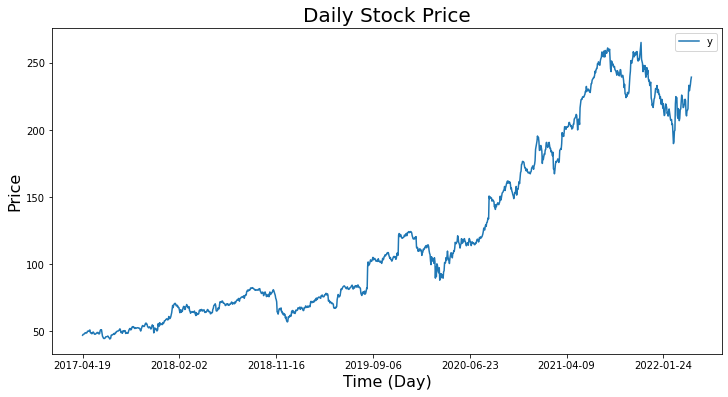

In [67]:
## Plot the data

def _fig_plot(df, X, Y):
  ''' Function plots the data. requires to provide dataframe in the
  format of date as ds, observation as y, Preset other variables e.g., axis name
  '''
  df.plot(x = X, y = Y, figsize=(12,6))
  plt.xlabel(xAxisLabel, fontsize = 16) # matplotlib.pyplot
  plt.ylabel(yAxisLabel, fontsize = 16)
  plt.title(Title, fontsize = 20)
  ax = plt.gca().get_xaxis()

Title = "Daily Stock Price"
xAxisLabel = 'Time (Day)'
yAxisLabel = 'Price'
_fig_plot(df, 'ds', 'y')

In [20]:
# divide the data into train and test set
df_train = df[:int(df.shape[0]*0.9)]
df_test = df[int(df.shape[0]*0.9):]

### Performance with base prophet

03:31:30 - cmdstanpy - INFO - Chain [1] start processing
03:31:31 - cmdstanpy - INFO - Chain [1] done processing


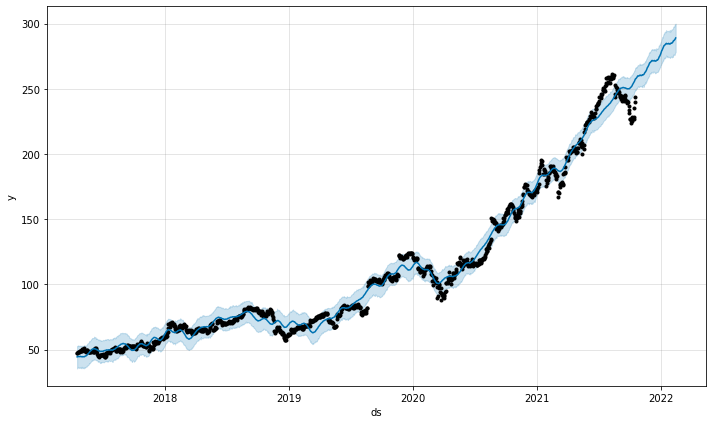

In [32]:
m = Prophet() # default values for seasonality, seasonality mode, 
m.fit(df_train)
future = m.make_future_dataframe(periods=120)
forecast_tr = m.predict(future)
m.plot(forecast_tr)
plt.show()

In [33]:
# compare with 
forecast_test = m.predict(df_test[['ds']])

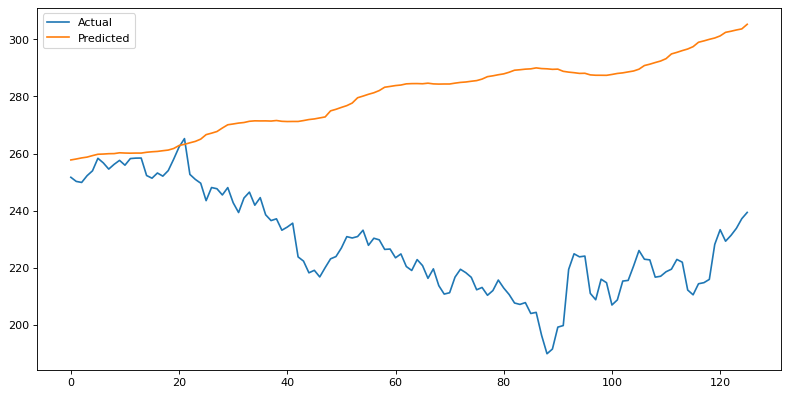

In [35]:
# plot expected vs actual
# compare with true values
forecast_test = m.predict(df_test[['ds']])
from matplotlib.pyplot import figure
figure(figsize=(12, 6), dpi=80)
plt.plot(df_test['y'].values, label='Actual')
plt.plot(forecast_test['yhat'].values, label='Predicted')
plt.legend()
plt.show()

In [59]:
# cross-validation performance
evaluation_model = cross_validation(m, initial='730 days', period='180 days', horizon = '10 days')
evaluation_metrix = performance_metrics(evaluation_model)
evaluation_metrix.sort_values('rmse').head(5)

  0%|          | 0/6 [00:00<?, ?it/s]

04:48:31 - cmdstanpy - INFO - Chain [1] start processing
04:48:31 - cmdstanpy - INFO - Chain [1] done processing
04:48:33 - cmdstanpy - INFO - Chain [1] start processing
04:48:33 - cmdstanpy - INFO - Chain [1] done processing
04:48:35 - cmdstanpy - INFO - Chain [1] start processing
04:48:36 - cmdstanpy - INFO - Chain [1] done processing
04:48:38 - cmdstanpy - INFO - Chain [1] start processing
04:48:38 - cmdstanpy - INFO - Chain [1] done processing
04:48:40 - cmdstanpy - INFO - Chain [1] start processing
04:48:41 - cmdstanpy - INFO - Chain [1] done processing
04:48:43 - cmdstanpy - INFO - Chain [1] start processing
04:48:43 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
4,5 days,39.334992,6.271761,5.243622,0.033690,0.032943,0.034415,0.50
3,4 days,60.524554,7.779753,6.733349,0.047727,0.043977,0.049513,0.25
9,10 days,136.604263,11.687783,9.218499,0.057048,0.056730,0.056141,0.25
8,9 days,168.490814,12.980401,9.892767,0.055885,0.049948,0.055261,0.25
7,8 days,248.623543,15.767801,11.624313,0.059632,0.052480,0.058535,0.25


# Improving model

### add holidays 

In [36]:
# import holidays
holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=[2017,2018,2019,2020,2021,2022]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

### change partition size

03:48:37 - cmdstanpy - INFO - Chain [1] start processing
03:48:39 - cmdstanpy - INFO - Chain [1] done processing


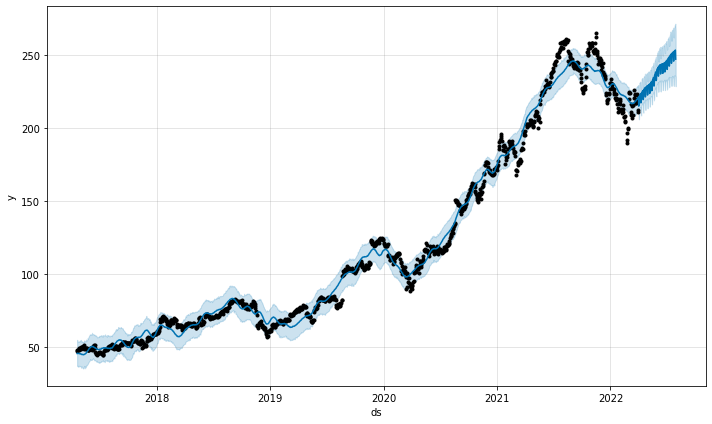

In [46]:
# create test dataset, remove last 100 days
train = df[:1249]
test = df[1249:]

m2 = Prophet(holidays=holiday) # include holiday parameter
m2.fit(train)

future = m2.make_future_dataframe(periods=120)
forecast_tr = m2.predict(future)
m2.plot(forecast_tr)
plt.show()

### tune hyper-parameters

In [47]:
# define the params grid
from sklearn.model_selection import ParameterGrid
params_grid = {
              'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]
               }
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 150


In [48]:
print('Training data, last date: ' + str(train.tail(1)['ds']) + ' ' + 'testing data, last date: ' + str(test.tail(1)['ds']))

Training data, last date: 1248    2022-04-01
Name: ds, dtype: object testing data, last date: 1258    2022-04-18
Name: ds, dtype: object


In [49]:
# search best hyper-parameters

strt='2022-04-02'
end='2020-04-12'

model_parameters = pd.DataFrame(columns = ['MAE','Parameters'])
for p in grid:
    LOL = pd.DataFrame()
    print(p)
#    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=p['weekly_seasonality'],
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='US')
    train_model.fit(train)
    future = train_model.make_future_dataframe(periods=10, freq='D',include_history = False)
    train_forecast = train_model.predict(future))
    LOL=train_forecast[['ds','yhat']]
    y_true= test['y'].values
    y_pred = LOL['yhat'][:len(y_true)].values
    mae = mean_absolute_error(y_true, y_pred)
    print('Mean Absolute Error: %.3f' % mae)
    model_parameters = model_parameters.append({'MAE':mae,'Parameters':p},ignore_index=True)

{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


03:51:37 - cmdstanpy - INFO - Chain [1] start processing
03:51:49 - cmdstanpy - INFO - Chain [1] done processing
03:51:52 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 17.241
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


03:51:58 - cmdstanpy - INFO - Chain [1] done processing
03:52:01 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 9.748
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


03:52:14 - cmdstanpy - INFO - Chain [1] done processing
03:52:18 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 17.539
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


03:52:32 - cmdstanpy - INFO - Chain [1] done processing
03:52:36 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 9.609
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


03:52:53 - cmdstanpy - INFO - Chain [1] done processing
03:52:57 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 16.724
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


03:53:13 - cmdstanpy - INFO - Chain [1] done processing
03:53:17 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 9.546
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


03:53:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 18.552
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


03:53:29 - cmdstanpy - INFO - Chain [1] start processing
03:53:36 - cmdstanpy - INFO - Chain [1] done processing
03:53:39 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 9.753
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


03:53:52 - cmdstanpy - INFO - Chain [1] done processing
03:53:55 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 16.679
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


03:54:07 - cmdstanpy - INFO - Chain [1] done processing
03:54:10 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 9.630
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


03:54:29 - cmdstanpy - INFO - Chain [1] done processing
03:54:34 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 17.721
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


03:54:50 - cmdstanpy - INFO - Chain [1] done processing
03:54:55 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 9.539
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


03:55:03 - cmdstanpy - INFO - Chain [1] done processing
03:55:07 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 18.884
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


03:55:13 - cmdstanpy - INFO - Chain [1] done processing
03:55:16 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 9.740
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


03:55:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 17.258
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


03:55:32 - cmdstanpy - INFO - Chain [1] start processing
03:55:42 - cmdstanpy - INFO - Chain [1] done processing
03:55:45 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 9.596
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


03:56:01 - cmdstanpy - INFO - Chain [1] done processing
03:56:05 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 17.407
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


03:56:21 - cmdstanpy - INFO - Chain [1] done processing
03:56:25 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 9.513
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


03:56:33 - cmdstanpy - INFO - Chain [1] done processing
03:56:36 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 18.151
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


03:56:44 - cmdstanpy - INFO - Chain [1] done processing
03:56:47 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 9.723
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


03:57:00 - cmdstanpy - INFO - Chain [1] done processing
03:57:03 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 16.414
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


03:57:11 - cmdstanpy - INFO - Chain [1] done processing
03:57:14 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 9.587
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


03:57:31 - cmdstanpy - INFO - Chain [1] done processing
03:57:35 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 18.056
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


03:57:50 - cmdstanpy - INFO - Chain [1] done processing
03:57:54 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 9.538
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


03:58:02 - cmdstanpy - INFO - Chain [1] done processing
03:58:05 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 17.637
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


03:58:12 - cmdstanpy - INFO - Chain [1] done processing
03:58:15 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 9.742
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


03:58:26 - cmdstanpy - INFO - Chain [1] done processing
03:58:29 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 18.606
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


03:58:39 - cmdstanpy - INFO - Chain [1] done processing
03:58:43 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 9.605
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


03:58:59 - cmdstanpy - INFO - Chain [1] done processing
03:59:03 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 16.878
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


03:59:19 - cmdstanpy - INFO - Chain [1] done processing
03:59:24 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 9.537
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


03:59:32 - cmdstanpy - INFO - Chain [1] done processing
03:59:35 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 20.066
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


03:59:42 - cmdstanpy - INFO - Chain [1] done processing
03:59:45 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 9.196
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


03:59:56 - cmdstanpy - INFO - Chain [1] done processing
03:59:59 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 19.962
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


04:00:10 - cmdstanpy - INFO - Chain [1] done processing
04:00:13 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 9.192
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


04:00:29 - cmdstanpy - INFO - Chain [1] done processing
04:00:32 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 18.094
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


04:00:47 - cmdstanpy - INFO - Chain [1] done processing
04:00:52 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 9.127
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


04:00:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 19.236
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


04:01:04 - cmdstanpy - INFO - Chain [1] start processing
04:01:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 9.239
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


04:01:19 - cmdstanpy - INFO - Chain [1] start processing
04:01:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 20.064
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


04:01:36 - cmdstanpy - INFO - Chain [1] start processing
04:01:53 - cmdstanpy - INFO - Chain [1] done processing
04:01:57 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 9.266
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


04:02:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 18.279
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


04:02:19 - cmdstanpy - INFO - Chain [1] start processing
04:02:36 - cmdstanpy - INFO - Chain [1] done processing
04:02:40 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 9.144
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


04:02:48 - cmdstanpy - INFO - Chain [1] done processing
04:02:50 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 19.224
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


04:02:58 - cmdstanpy - INFO - Chain [1] done processing
04:03:01 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 9.216
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


04:03:14 - cmdstanpy - INFO - Chain [1] done processing
04:03:17 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 18.567
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


04:03:28 - cmdstanpy - INFO - Chain [1] done processing
04:03:31 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 9.186
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


04:03:47 - cmdstanpy - INFO - Chain [1] done processing
04:03:51 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 18.034
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


04:03:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 9.238
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


04:04:08 - cmdstanpy - INFO - Chain [1] start processing
04:04:20 - cmdstanpy - INFO - Chain [1] done processing
04:04:25 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 18.370
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


04:04:35 - cmdstanpy - INFO - Chain [1] done processing
04:04:38 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 9.233
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


04:04:51 - cmdstanpy - INFO - Chain [1] done processing
04:04:54 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 17.194
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


04:05:04 - cmdstanpy - INFO - Chain [1] done processing
04:05:07 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 9.252
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


04:05:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 17.906
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


04:05:30 - cmdstanpy - INFO - Chain [1] start processing
04:05:45 - cmdstanpy - INFO - Chain [1] done processing
04:05:49 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 9.124
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


04:05:57 - cmdstanpy - INFO - Chain [1] done processing
04:05:59 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 18.440
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


04:06:08 - cmdstanpy - INFO - Chain [1] done processing
04:06:11 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 9.252
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


04:06:22 - cmdstanpy - INFO - Chain [1] done processing
04:06:25 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 18.416
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


04:06:42 - cmdstanpy - INFO - Chain [1] done processing
04:06:47 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 9.208
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


04:07:02 - cmdstanpy - INFO - Chain [1] done processing
04:07:08 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 18.986
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


04:07:24 - cmdstanpy - INFO - Chain [1] done processing
04:07:28 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 9.123
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


04:07:37 - cmdstanpy - INFO - Chain [1] done processing
04:07:40 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 18.976
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


04:07:47 - cmdstanpy - INFO - Chain [1] done processing
04:07:50 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 8.347
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


04:08:01 - cmdstanpy - INFO - Chain [1] done processing
04:08:04 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 17.924
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


04:08:14 - cmdstanpy - INFO - Chain [1] done processing
04:08:18 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 8.306
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


04:08:34 - cmdstanpy - INFO - Chain [1] done processing
04:08:38 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 17.790
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


04:08:52 - cmdstanpy - INFO - Chain [1] done processing
04:08:56 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 8.328
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


04:09:04 - cmdstanpy - INFO - Chain [1] done processing
04:09:06 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 18.834
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


04:09:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 8.437
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


04:09:26 - cmdstanpy - INFO - Chain [1] start processing
04:09:44 - cmdstanpy - INFO - Chain [1] done processing
04:09:49 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 16.641
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


04:10:09 - cmdstanpy - INFO - Chain [1] done processing
04:10:14 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 8.351
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


04:10:34 - cmdstanpy - INFO - Chain [1] done processing
04:10:39 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 17.662
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


04:10:57 - cmdstanpy - INFO - Chain [1] done processing
04:11:04 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 8.284
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


04:11:12 - cmdstanpy - INFO - Chain [1] done processing
04:11:15 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 18.661
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


04:11:23 - cmdstanpy - INFO - Chain [1] done processing
04:11:26 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 8.474
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


04:11:40 - cmdstanpy - INFO - Chain [1] done processing
04:11:47 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 18.416
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


04:12:02 - cmdstanpy - INFO - Chain [1] done processing
04:12:06 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 8.345
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


04:12:20 - cmdstanpy - INFO - Chain [1] done processing
04:12:24 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 18.183
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


04:12:40 - cmdstanpy - INFO - Chain [1] done processing
04:12:44 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 8.375
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


04:12:53 - cmdstanpy - INFO - Chain [1] done processing
04:12:56 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 18.443
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


04:13:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 8.332
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


04:13:07 - cmdstanpy - INFO - Chain [1] start processing
04:13:21 - cmdstanpy - INFO - Chain [1] done processing
04:13:24 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 18.131
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


04:13:38 - cmdstanpy - INFO - Chain [1] done processing
04:13:41 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 8.600
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


04:13:58 - cmdstanpy - INFO - Chain [1] done processing
04:14:02 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 18.931
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


04:14:18 - cmdstanpy - INFO - Chain [1] done processing
04:14:22 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 8.258
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


04:14:30 - cmdstanpy - INFO - Chain [1] done processing
04:14:33 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 20.928
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


04:14:41 - cmdstanpy - INFO - Chain [1] done processing
04:14:45 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 8.638
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


04:14:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 18.927
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


04:15:04 - cmdstanpy - INFO - Chain [1] start processing
04:15:17 - cmdstanpy - INFO - Chain [1] done processing
04:15:20 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 8.318
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


04:15:41 - cmdstanpy - INFO - Chain [1] done processing
04:15:45 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 17.497
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


04:15:59 - cmdstanpy - INFO - Chain [1] done processing
04:16:03 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 8.066
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


04:16:11 - cmdstanpy - INFO - Chain [1] done processing
04:16:14 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 19.112
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


04:16:21 - cmdstanpy - INFO - Chain [1] done processing
04:16:24 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 7.897
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


04:16:35 - cmdstanpy - INFO - Chain [1] done processing
04:16:38 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 19.266
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


04:16:48 - cmdstanpy - INFO - Chain [1] done processing
04:16:52 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 7.934
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


04:17:12 - cmdstanpy - INFO - Chain [1] done processing
04:17:17 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 18.304
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


04:17:31 - cmdstanpy - INFO - Chain [1] done processing
04:17:35 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 7.949
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


04:17:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 18.704
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


04:17:47 - cmdstanpy - INFO - Chain [1] start processing
04:17:57 - cmdstanpy - INFO - Chain [1] done processing
04:18:00 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 8.275
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


04:18:11 - cmdstanpy - INFO - Chain [1] done processing
04:18:14 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 18.975
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


04:18:23 - cmdstanpy - INFO - Chain [1] done processing
04:18:27 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 8.087
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


04:18:40 - cmdstanpy - INFO - Chain [1] done processing
04:18:44 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 17.290
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


04:18:58 - cmdstanpy - INFO - Chain [1] done processing
04:19:02 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 7.886
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


04:19:11 - cmdstanpy - INFO - Chain [1] done processing
04:19:14 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 19.894
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


04:19:22 - cmdstanpy - INFO - Chain [1] done processing
04:19:25 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 7.853
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


04:19:36 - cmdstanpy - INFO - Chain [1] done processing
04:19:40 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 17.463
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


04:19:51 - cmdstanpy - INFO - Chain [1] done processing
04:19:55 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 7.958
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


04:20:11 - cmdstanpy - INFO - Chain [1] done processing
04:20:15 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 18.969
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


04:20:30 - cmdstanpy - INFO - Chain [1] done processing
04:20:34 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 7.659
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


04:20:42 - cmdstanpy - INFO - Chain [1] done processing
04:20:45 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 19.147
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


04:20:53 - cmdstanpy - INFO - Chain [1] done processing
04:20:56 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 8.288
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


04:21:08 - cmdstanpy - INFO - Chain [1] done processing
04:21:12 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 20.407
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


04:21:23 - cmdstanpy - INFO - Chain [1] done processing
04:21:27 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 7.991
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


04:21:42 - cmdstanpy - INFO - Chain [1] done processing
04:21:46 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 17.757
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


04:22:01 - cmdstanpy - INFO - Chain [1] done processing
04:22:05 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 7.861
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


04:22:13 - cmdstanpy - INFO - Chain [1] done processing
04:22:18 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 18.969
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


04:22:25 - cmdstanpy - INFO - Chain [1] done processing
04:22:28 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 8.152
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


04:22:39 - cmdstanpy - INFO - Chain [1] done processing
04:22:43 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 19.639
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


04:22:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 7.795
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


04:22:57 - cmdstanpy - INFO - Chain [1] start processing
04:23:12 - cmdstanpy - INFO - Chain [1] done processing
04:23:16 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 18.348
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


04:23:32 - cmdstanpy - INFO - Chain [1] done processing
04:23:35 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 7.787
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


04:23:43 - cmdstanpy - INFO - Chain [1] done processing
04:23:46 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 18.147
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


04:23:53 - cmdstanpy - INFO - Chain [1] done processing
04:23:56 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 7.801
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


04:24:06 - cmdstanpy - INFO - Chain [1] done processing
04:24:10 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 20.342
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


04:24:20 - cmdstanpy - INFO - Chain [1] done processing
04:24:24 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 7.832
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


04:24:40 - cmdstanpy - INFO - Chain [1] done processing
04:24:44 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 19.079
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


04:24:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 7.711
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


04:25:03 - cmdstanpy - INFO - Chain [1] start processing
04:25:10 - cmdstanpy - INFO - Chain [1] done processing
04:25:13 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 19.527
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


04:25:21 - cmdstanpy - INFO - Chain [1] done processing
04:25:23 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 7.915
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


04:25:35 - cmdstanpy - INFO - Chain [1] done processing
04:25:38 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 17.238
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


04:25:49 - cmdstanpy - INFO - Chain [1] done processing
04:25:52 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 7.870
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


04:26:06 - cmdstanpy - INFO - Chain [1] done processing
04:26:10 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 18.448
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


04:26:23 - cmdstanpy - INFO - Chain [1] done processing
04:26:27 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 7.748
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


04:26:35 - cmdstanpy - INFO - Chain [1] done processing
04:26:37 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 18.378
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


04:26:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 7.882
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


04:26:49 - cmdstanpy - INFO - Chain [1] start processing
04:26:59 - cmdstanpy - INFO - Chain [1] done processing
04:27:02 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 18.993
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


04:27:11 - cmdstanpy - INFO - Chain [1] done processing
04:27:14 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 7.849
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


04:27:27 - cmdstanpy - INFO - Chain [1] done processing
04:27:30 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 17.868
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


04:27:43 - cmdstanpy - INFO - Chain [1] done processing
04:27:46 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 7.665
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


04:27:53 - cmdstanpy - INFO - Chain [1] done processing
04:27:56 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 19.344
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


04:28:03 - cmdstanpy - INFO - Chain [1] done processing
04:28:06 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 7.767
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


04:28:16 - cmdstanpy - INFO - Chain [1] done processing
04:28:19 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 18.634
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


04:28:29 - cmdstanpy - INFO - Chain [1] done processing
04:28:32 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 7.800
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


04:28:45 - cmdstanpy - INFO - Chain [1] done processing
04:28:49 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 18.583
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


04:29:02 - cmdstanpy - INFO - Chain [1] done processing
04:29:06 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 7.821
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


04:29:13 - cmdstanpy - INFO - Chain [1] done processing
04:29:16 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 19.388
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


04:29:23 - cmdstanpy - INFO - Chain [1] done processing
04:29:25 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 7.877
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


04:29:36 - cmdstanpy - INFO - Chain [1] done processing
04:29:39 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 16.673
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


04:29:49 - cmdstanpy - INFO - Chain [1] done processing
04:29:52 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 7.832
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


04:30:06 - cmdstanpy - INFO - Chain [1] done processing
04:30:10 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 17.966
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


04:30:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 7.836


In [51]:
parameters = model_parameters.sort_values(by=['MAE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,MAE,Parameters
0,7.659429,"{'changepoint_prior_scale': 0.4, 'holidays_pri..."
1,7.664958,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
2,7.710639,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
3,7.748364,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
4,7.767085,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."


In [52]:
#Best Parameters on which the model has the least MAPE is:
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.4,
 'holidays_prior_scale': 0.3,
 'n_changepoints': 200,
 'seasonality_mode': 'additive'}

# Performance with tuned-model

In [53]:
# Setup and train model with holidays
final_model = Prophet(holidays=holiday,
                      changepoint_prior_scale= 0.4,
                      holidays_prior_scale = 0.3,
                      n_changepoints = 200,
                      seasonality_mode = 'additive',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_model.add_country_holidays(country_name='US')
final_model.fit(train)

04:34:11 - cmdstanpy - INFO - Chain [1] start processing
04:34:24 - cmdstanpy - INFO - Chain [1] done processing


In [54]:
future = final_model.make_future_dataframe(periods=10, freq='D')
forecast = final_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
1252,2022-04-05,223.694354,216.415279,230.355179
1253,2022-04-06,224.243233,217.132740,231.626248
1254,2022-04-07,224.716058,216.793777,232.156188
1255,2022-04-08,225.475339,218.181178,232.625841
1256,2022-04-09,223.242371,215.938792,230.541573
1257,2022-04-10,223.758145,216.648712,231.312002
1258,2022-04-11,226.967091,219.207456,234.687096


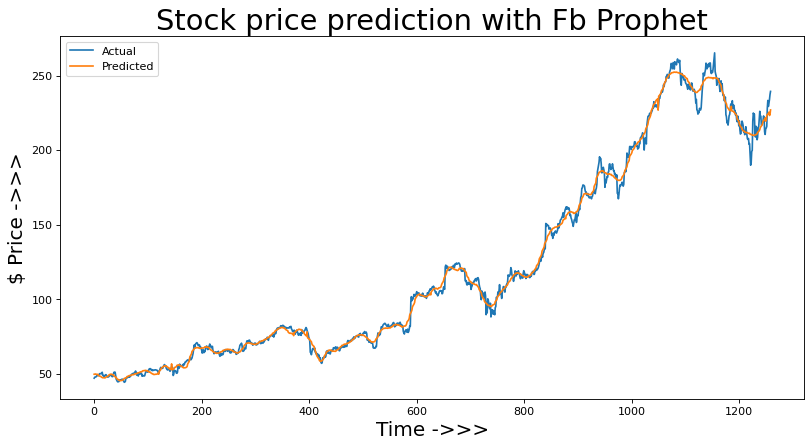

In [69]:
figure = plt.figure(figsize=(12, 6), dpi=80)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time ->>>', fontsize = 18)
plt.ylabel('$ Price ->>>', fontsize = 18)
plt.title('Stock price prediction with Fb Prophet', fontsize = 26)
plt.legend()
plt.show()

In [55]:
# plot forecast vs actual
y_true= df['y'].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('Mean Absolute Error: %.3f' % mae)


Mean Absolute Error: 2.713


In [60]:
# cross-validation performance
evaluation_model = cross_validation(final_model, initial='720 days', period='180 days', horizon = '10 days')
evaluation_metrix = performance_metrics(evaluation_model)
evaluation_metrix.sort_values('rmse').head(5)

  0%|          | 0/6 [00:00<?, ?it/s]

04:50:23 - cmdstanpy - INFO - Chain [1] start processing
04:50:27 - cmdstanpy - INFO - Chain [1] done processing
04:50:31 - cmdstanpy - INFO - Chain [1] start processing
04:50:39 - cmdstanpy - INFO - Chain [1] done processing
04:50:44 - cmdstanpy - INFO - Chain [1] start processing
04:50:50 - cmdstanpy - INFO - Chain [1] done processing
04:50:54 - cmdstanpy - INFO - Chain [1] start processing
04:51:01 - cmdstanpy - INFO - Chain [1] done processing
04:51:04 - cmdstanpy - INFO - Chain [1] start processing
04:51:12 - cmdstanpy - INFO - Chain [1] done processing
04:51:15 - cmdstanpy - INFO - Chain [1] start processing
04:51:24 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,6.049710,2.459616,1.628013,0.011071,0.005577,0.011185,0.75
5,6 days,12.625139,3.553187,3.291983,0.025415,0.028171,0.025769,0.75
1,2 days,40.833675,6.390123,4.862734,0.029960,0.028752,0.030457,0.50
3,4 days,41.331851,6.428985,5.256050,0.030901,0.030171,0.031551,0.50
2,3 days,50.651705,7.117001,5.060838,0.029377,0.026182,0.030141,0.50
